In [155]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import scipy.integrate as sci
import time 
import threading
import sys
import multiprocessing as multiproc
import datetime
# the function library
from projectlib import *

## Parameters

**Fehler der Parameter wird aus der Datei "Optimale Parameter" entnommen**

In [156]:
alpha =  0.47708333 
beta = 0.24666667
d_alpha = 2.8594829541976186
d_beta = 0.9765988574749895

method = 'heaviside'
dimension = 12
number_of_Lks = dimension
params_12_heavi = np.array([alpha, beta, 2.64e-2])
d_params_12_heavi = np.array([d_alpha, d_beta])

In [157]:
alpha =  0.39945343
beta = 0.3660048
d_alpha = 0.10844247052599596
d_beta = 0.10598828148500454
method = 'constant'
dimension = 12
number_of_Lks = dimension
params_12_const = np.array([alpha, beta, 2.64e-2])
d_params_12_const = np.array([d_alpha, d_beta])

In [158]:
alpha =  0.32912736
beta = 0.29507202
d_alpha = 0.07887398474089544
d_beta = 0.07716644664153446
method = 'constant'
dimension = 38
number_of_Lks = dimension
params_38_const = np.array([alpha, beta, 2.64e-2])
d_params_38_const = np.array([d_alpha, d_beta])

In [159]:

alpha =  0.44506836
beta = 0.25511719 
d_alpha = 0.16961969327169434
d_beta = 0.0953716739387912
method = 'heaviside'
dimension = 38
number_of_Lks = dimension
params_38_heavi = np.array([alpha, beta, 2.64e-2])
d_params_38_heavi = np.array([d_alpha, d_beta])

## Simulation 

In [160]:
class Data:
    def __init__(self, alpha, beta, dimension, name, commuters_day, N):
        "Dimension gives the dimension of the system, i.e. number of cells"
        # ------- TO DO ---------
        # Depending on the system this has to be adjusted
        self.dimension = dimension
        
        "Alpha describes the rate of infection"
        self.alpha = alpha # Dimensions day^(-1)

        "Beta describes the recovery rate"
        self.beta = beta # Dimensions day^(-1)

        "p is the probability to die from the disease"
        self.p = 2.64e-2
        
        """
        Commuters is an array describing the commuters from and to the different cells. 
        The structure is: The entries in column i are how many commute from i to the cell of the row.
                          Thus, the entries of the row i describe how many commute from different cells to cell i.
        """

        self.commuters = np.array([np.ones(self.dimension) for i in range(self.dimension)])
        "load the txt with given name"
        file = np.loadtxt(name, delimiter="\t")
        "fill commuters with the entries from the file. Note the break statement so it doesn't go to far"
        i = 0
        for row in file:
            if i >= self.dimension:
                break
            self.commuters[i] = np.asarray(row[0:self.dimension])
            i += 1
        
        "Part of day that commuters are in other cells. This is the same value for all cells"
        self.commuters_day = commuters_day

        "Array of population in every cell"
        # ------- TO DO ---------
        # figure out how to best do this
        self.N = N

        
        
    def commutersFrom(self, cfrom):
        """Function to extract the commuters from a cell

        Args:
            cfrom (integer): the cell 

         Returns:
            array: array containing commuters from cfrom
        """
        # ------- TO DO ---------
        # optimize the algorithm
        "Sorting out the necessary entries into array a."
        a = np.zeros(self.dimension)
        for i in range(self.dimension):
            a[i] = self.commuters[i][cfrom]
            
        return a 
    
    def commutersTo(self, cto):
        """Function to return an array with number of commuters coming to cto from other cells.

        Args:
            cto (integer): the cell to which the commuters travel

        Returns:
            array: array containing the commuters to cto.
        """
        return self.commuters[cto][:]
    

### Simulation Functions

In [161]:

def function_of_system(timestep, functions,  data, method, t0):
    """Function to calculate the time derivatives of the dynamic SIRD modell with commuters. This function uses multiple approachs for different variant of the system based on prior assumptions. 

        Args:
            functions (array): array with the functions that define the system of equations. Structure [S_1, ... , S_n, I_1, .... , I_n, R_1, ... , R_n, D_1, ... , D_n]
            timestep (float): time of timestep. t=1 is 1 day
            data (class): the class with the relevant data
            method (string): dictates what method is to be used. The choices are "constant", "heaviside"
            t0 (array): array with len = 3 filled with times at which the heaviside functions in the "heaviside" method switch. 
                Note: all values of t0 have to be between 0 and 1.

        Returns:
            array: array containing the derivatives of functions at time t.
    """
    # array with infected
    Infected = functions[data.dimension:2*data.dimension]

    # making array with the effective infected Ieff
    Ieff = np.array([effective_infected(data.commutersTo, data.commutersFrom, data.N, i, Infected, data.dimension) for i in range(data.dimension)])

    # initializing the return array with the time derivatives of functions
    dfuncdt = np.ones(data.dimension*4)

    "~~~~~~~~~~~~~~~~~ See the PDF / LaTeX for further explanation of the equations ~~~~~~~~~~~~~~~~~~~~~~~~"

    ## ------------------------------------
    # -     Without commuting effects    -
    # ------------------------------------

    if method == 'simple':

        for i in range(data.dimension):
            # see LaTeX for equations
            # dS/dt
            dfuncdt[i] =  - data.alpha *  functions[i] * Infected[i]

            # dI/dt \propto -dSdt
            dfuncdt[i + data.dimension] = - dfuncdt[i] - data.beta * Infected[i]

            # dR/dt
            dfuncdt[i + 2 * data.dimension] = (1 - data.p) * data.beta * Infected[i]

            # dD/dt
            dfuncdt[i + 3 * data.dimension] = data.p * data.beta * Infected[i] 


    # ------------------------------------
    # -      Constant Coefficients       -
    # ------------------------------------

    tt = 0.6 #time in home vertex

    if method == "constant":
            
        # the for loop to fill dfuncdt

        for i in range(data.dimension):
            # see LaTeX for equations
            # dS/dt
            dfuncdt[i] =  - tt * data.alpha *  functions[i] * functions[i + data.dimension] - (1 - tt) * data.alpha * functions[i] * Ieff[i]

            # dI/dt \propto -dSdt
            dfuncdt[i + data.dimension] = - dfuncdt[i] - data.beta * functions[i + data.dimension]

            # dR/dt
            dfuncdt[i + 2 * data.dimension] = (1 - data.p) * data.beta * functions[i + data.dimension]

            # dD/dt
            dfuncdt[i + 3 * data.dimension] = data.p * data.beta * functions[i + data.dimension]


    # ------------------------------------
    # -      Heaviside Coefficients      -
    # ------------------------------------


    elif method == "heaviside":


        # the for loop to fill dfuncdt
        for i in range(data.dimension):
            # see LaTeX for equations
            # dS/dt
            dfuncdt[i] = - data.alpha * (periodic_heaviside(timestep, t0[0]) + periodic_heaviside(timestep, t0[2]) - 1) * functions[i] * functions[i + data.dimension] - (periodic_heaviside(timestep, t0[1]) - periodic_heaviside(timestep, t0[2])) * data.alpha * functions[i] * Ieff[i]

            # dI/dt \propto -dSdt
            dfuncdt[i + data.dimension] = - dfuncdt[i] - data.beta * functions[i + data.dimension]

            # dR/dt
            dfuncdt[i + 2 * data.dimension] = (1 - data.p) * data.beta * functions[i + data.dimension]

            # dD/dt
            dfuncdt[i + 3 * data.dimension] = data.p * data.beta * functions[i + data.dimension]

    
    
    
    
    
    
    
    # returning the derivatives at time t
    return dfuncdt



# Function for using scipy.integrate.odeint, as the arguments are switched
def system_function(functions, timestep, data, method, t0):
    return function_of_system(timestep, functions, data, method, t0)




### Initial Values

In [248]:

M =  region_setup(38)[0]
N = import_rki_data(M, 7)[2]
M_ =  region_setup(12)[0]
N_ = import_rki_data(M, 7)[2]

#N_ enthält Anzahl der Bevölkerung der Landkreis
RKI_data = np.load("Internal Data/timeline.npy")
I_RKI = np.array([RKI_data[i][1] for i in range(38)])
#I_RKI[Landkreis][Tag]

In [163]:
commuters = np.array([np.ones(dimension) for i in range(dimension)])
file = np.loadtxt("Pendler.txt", delimiter="\t")
"fill commuters with the entries from the file. Note the break statement so it doesn't go to far"
i = 0
for row in file:
    if i >= dimension:
        break
    commuters[i] = np.asarray(row[0:dimension])
    i += 1

### Simulation and Initial uncertainty

In [246]:
tzero = np.array([0, 0.4, 0.8])
def make_sim(parameters, d_params, method , number_of_regions, t_depth = 100):
    
    """starts a simulation with the given parameter in params
    returns 1)inital uncertainty based on d_params
            2) array of time points on which the simulation is evaluated
            3) simulated SIRD for the first regions on these timepoints
    """
    
    dimension = number_of_regions
    Sigma_state_38 = []
    Sigma_state_12 = []
    if dimension==12:
        a = initial_compartment_distribution(12, "2020/07/24")
        initCond = np.zeros(12*4)
        for i in range(12):
            initCond[i] = a[i][0]
            initCond[i + 12] = a[i][1]
            initCond[i + 12*2] = a[i][2]
            initCond[i + 12*3] = a[i][3]
            
        Sigma_state_12 = [max(initCond[i]*0.01, \
                               1/N[i % dimension]) for i in range(4*dimension)]
        Sigma_state = np.array(Sigma_state_12)
        X = initCond
        Z = N_
    elif dimension==38:
        b = initial_compartment_distribution(38, "2020/07/24")
        initCond38 = np.zeros(38*4)
        for i in range(38):
            initCond38[i] = b[i][0]
            initCond38[i + 38] = b[i][1]
            initCond38[i + 38*2] = b[i][2]
            initCond38[i + 38*3] = b[i][3]
            
        Sigma_state_38 = [max(initCond38[i]*0.01, \
                               1/N[i % dimension]) for i in range(4*dimension)]
        Sigma_state = np.array(Sigma_state_38)
        X = initCond38
        Z = N
    
    Sigma_params = np.array([d_params[0],d_params[1],0])
    Sigma = np.diag(np.concatenate((Sigma_state,Sigma_params), axis=0, out=None, dtype=None, casting="same_kind"))
    for i in range(len(Sigma_state)):
        if Sigma_state[i]<0:
            j = i % dimension
            if abs(N[j]*Sigma_state[i])<5:
                Sigma[i][i] = 2*abs(Sigma_state[i])
            else:
                print("Initial conditions are wrong!")
    simulation001 = Data(parameters[0], parameters[1], number_of_regions, "Pendler.txt", 0.6, Z)
    t = np.linspace(0,100, t_depth)
    params = [parameters[0], parameters[1], 2.64e-2]
    sol = sci.solve_ivp(fun=function_of_system, t_span=(0, 100),\
              y0=X, method="RK45", args=(simulation001, method, tzero), t_eval=t, dense_output=True)
    state = sol.y
    solt = sol.t
    return Sigma, solt, state

## Jacobian

In [165]:
def commutersFrom(cfrom):
    """Function to extract the commuters from a cell

    Args:
        cfrom (integer): the cell 

     Returns:
        array: array containing commuters from cfrom
    """

    "Sorting out the necessary entries into array a."
    a = np.zeros(dimension)
    for i in range(dimension):
        a[i] = commuters[i][cfrom]
            
    return a 
    
def commutersTo(cto):
    """Function to return an array with number of commuters coming to cto from other cells.

    Args:
        cto (integer): the cell to which the commuters travel

    Returns:
        array: array containing the commuters to cto.
    """
    return commuters[cto][:]
       


def I_eff(infected, i, t = 0):
    """Function for effective infected

    Args:
        infected (array): array with infected
        i (int): what cell
        t (int): time in days (counted from simmulation start)

    Returns:
        float: effective population in cell i
    """
    return effective_infected(commutersTo, commutersFrom, N, i, infected, dimension)

def N_eff(i):
    """Effective population

    Args:
        i (int): what cell
        t (int): time in days (counted from simmulation start)

    Returns:
        float: effective population in cell i
    """
    return N[i] - np.sum(commutersFrom(i))

def P(i,j,t = 0):
    return commuters[j][i]


In [166]:
def delta_kronecker(i, j):
    if i == j:
        return 1
    else:
        return 0

def ds(state, number_of_Lks, method, params, i, t):
    """
    Returns dS/dt in Region i at time t*
            whereas t* is the time of the t-th element in state[0]
    Args: 
            state: solution using scipy.integrate
            number_of_Lks; number of simulated regions
            params: parameter of the simulation
    """
    alpha = params[0]
    beta = params[1]
    S = state[0:number_of_Lks,t]
    I = state[number_of_Lks:2*number_of_Lks,t]
    R = state[2*number_of_Lks:3*number_of_Lks,t]
    D = state[3*number_of_Lks:4*number_of_Lks,t]
    #res = 0
    #for j in range(number_of_Lks):
    #    res = res + P(i,j,t) * I_eff(I, j, t)
    
    return -method[0] * alpha * S[i] * I[i] - method[1] * alpha * I_eff(I, i, t)* S[i]
           #(N_eff(i)* S[i] *I_eff(I, i, t)  + S[i] * res) / N[i]

def dI(state, number_of_Lks, method, params, i, t):
    """
    Returns dI/dt in Region i at time t*
            whereas t* is the time of the t-th element in state[0]
    Args: 
            state: solution using scipy.integrate
            number_of_Lks; number of simulated regions
            params: parameter of the simulation
    """
    alpha = params[0]
    beta = params[1] 
    S = state[0:number_of_Lks,t]
    I = state[number_of_Lks:2*number_of_Lks,t]
    R = state[2*number_of_Lks:3*number_of_Lks,t]
    D = state[3*number_of_Lks:4*number_of_Lks,t]
    
    res = 0
    #for j in range(number_of_Lks):
    #    res = res + P(i,j,t) * I_eff(I, j, t)
    return - method[0] * alpha * S[i] * I[i] + method[1] * alpha *S[i] *I_eff(I, i, t) - beta * I[i]


def dR(state , number_of_Lks , params, i, t):
    """
    Returns dR/dt in Region i at time t*
            whereas t* is the time of the t-th element in state[0]
    Args: 
            state: solution using scipy.integrate
            number_of_Lks; number of simulated regions
            params: parameter of the simulation
    """
    beta = params[1]
    p = params[2]
    S = state[0:number_of_Lks,t]
    I = state[number_of_Lks:2*number_of_Lks,t]
    R = state[2*number_of_Lks:3*number_of_Lks,t]
    D = state[3*number_of_Lks:4*number_of_Lks,t]
    return (1-p) * beta * I[i]

def dD(state , number_of_Lks , params, i, t):
    """
    Returns dD/dt in Region i at time t*
            whereas t* is the time of the t-th element in state[0]
    Args: 
            state: solution using scipy.integrate
            number_of_Lks; number of simulated regions
            params: parameter of the simulation
    """
    p = params[2]
    S = state[0:number_of_Lks,t]
    I = state[number_of_Lks:2*number_of_Lks,t]
    R = state[2*number_of_Lks:3*number_of_Lks,t]
    D = state[3*number_of_Lks:4*number_of_Lks,t]
    return (p) * beta * I[i]


In [167]:
def Jacobian_SS(state, number_of_Lks, method, params, t):
    """
    Returns: a (number_of_Lks,number_of_Lks) block matrix wich
            coresponds with (d(dS_i/dt)/dS_j) at time t*
            whereas t* is the time of the t-th element in state[0]
            both i and j are regions of the simulation
    Args: 
            state: solution using scipy.integrate
            number_of_Lks; number of simulated regions
            params: parameter of the simulation
    """
    S = state[0:number_of_Lks,t]
    I = state[number_of_Lks:2*number_of_Lks,t]
    R = state[2*number_of_Lks:3*number_of_Lks,t]
    D = state[3*number_of_Lks:4*number_of_Lks,t]
    n = number_of_Lks
    J_SS = np.identity(n)
    for i in range(n):
        J_SS[i][i] = ds(state, number_of_Lks, method, params, i, t)/S[i]
    return J_SS

def Jacobian_SI(state, number_of_Lks, method, params, t):
    """
    Returns: a (number_of_Lks,number_of_Lks) block matrix wich
            coresponds with d(d(dS_i/dt)/dI_j at time t*
            whereas t* is the time of the t-th element in state[0]
            both i and j are regions of the simulation
    Args: 
            state: solution using scipy.integrate
            number_of_Lks; number of simulated regions
            params: parameter of the simulation
    """
    n = number_of_Lks
    alpha = params[0]
    beta = params[1]
    J_SI = np.identity(n)
    S = state[0:number_of_Lks,t]

    P = commuters
    Nr = np.array([N_eff(i) for i in range(n)])
    


    sumba = np.array([np.zeros(n) for i in range(n)])
    for i in range(n):
        for j in range(n):
                for l in range(n):
                    sumba[i, j] += P[l, i] * P[l, j] / (Nr[l] + sum(P[l, :]))
                sumba[i, j] *= 1.0 / N[i]


    for i in range(number_of_Lks):
        for j in range(number_of_Lks):
            if (i == j):
                J_SI[i, j] = ((method[1] * Nr[i]**2 / (N[i] * (Nr[i] + sum(P[i, :])))) + method[0]) * S[i]
            else:
                J_SI[i, j] =  method[1] * (P[i, j] * Nr[i] / (N[i] * (Nr[i] + sum(P[i, :]))) + P[j, i] * Nr[j] / (N[i] * (Nr[j] + sum(P[j, :]))) + sumba[i, j]) * S[i]
    
    return - alpha * J_SI




def Jacobian_RI(state, number_of_Lks, method, params, t):
    """
    Returns: a (number_of_Lks,number_of_Lks) block matrix wich
            coresponds with (d(dR_i/dt)/dI_j) at time t*
            whereas t* is the time of the t-th element in state[0]
            both i and j are regions of the simulation
    Args: 
            state: solution using scipy.integrate
            number_of_Lks; number of simulated regions
            params: parameter of the simulation
    """
    n = number_of_Lks
    alpha = params[0]
    beta = params[1] 
    p = params[2]
    J_RI = np.identity(n)
    for i in range(n):
        for l in range(n):
            J_RI[i][l] = delta_kronecker(i, l) * (1 - p) * beta
    return J_RI

def Jacobian_DI(state, number_of_Lks, method, params, t):
    """
    Returns: a (number_of_Lks,number_of_Lks) block matrix wich
            coresponds with (d(dD_i/dt)/dI_j) at time t*
            whereas t* is the time of the t-th element in state[0]
            both i and j are regions of the simulation
    Args: 
            state: solution using scipy.integrate
            number_of_Lks; number of simulated regions
            params: parameter of the simulation
    """
    n = number_of_Lks
    alpha = params[0]
    beta = params[1]
    p = params[2]
    J_DI = np.identity(n)
    for i in range(n):
        for l in range(n):
            J_DI[i][l] = delta_kronecker(i, l) * p * beta
    return J_DI

def Jacobian_IS(state, number_of_Lks, method, params, t):
    """
    Returns: a (number_of_Lks,number_of_Lks) block matrix wich
            coresponds with (d(dI_i/dt)/dS_j) at time t*
            whereas t* is the time of the t-th element in state[0]
            both i and j are regions of the simulation

    Args: 
            state: solution using scipy.integrate
            number_of_Lks; number of simulated regions
            params: parameter of the simulation
    """
    return -1* Jacobian_SS(state, number_of_Lks, method, params, t)

def Jacobian_II(state, number_of_Lks, method, params, t):
    """
    Returns: a (number_of_Lks,number_of_Lks) block matrix wich
            coresponds with (d(dI_i/dt)/dI_j) at time t*
            whereas t* is the time of the t-th element in state[0]
            both i and j are regions of the simulation
    Args: 
            state: solution using scipy.integrate
            number_of_Lks; number of simulated regions
            params: parameter of the simulation
    """
    n = number_of_Lks
    beta = params[1]

    J_intermed = - Jacobian_SI(state, number_of_Lks, method, params, t)

    J_II = J_intermed - beta * np.identity(n)

    return J_II

In [168]:
def Jacobian(state, solt , number_of_Lks, method, params, t):
    """
    Returns: a (4*number_of_Lks,4*number_of_Lks) block matrix wich
            coresponds with the jacobian J_x at time t*
            whereas t*= solt[t]
        
    Args: 
            state: solution using scipy.integrate
            solt: array of time point on which state is evaluated
            method: either 'constant' or 'heaviside' 
            number_of_Lks; number of simulated regions
            params: parameter of the simulation
    """
    time_of_day = solt[t] - np.floor(solt[t])
    T = [0.6,0.4]
    if method=='constant':
        T = [0.6,0.4]
    elif method=='heaviside':
        if time_of_day >=tzero[0] and time_of_day <= tzero[1]:
            T = [1,0]
        else:
            T = [0,1]
    else:
        print("invalid Method")
        T = [0.6,0.4]
        
    J_SS = Jacobian_SS(state, number_of_Lks, T, params, t)
    J_SI = Jacobian_SI(state, number_of_Lks, T, params, t)
    J_SR = np.identity(number_of_Lks)*0
    J_SD = np.identity(number_of_Lks) * 0
    
    J_IS = Jacobian_IS(state, number_of_Lks, T, params, t)
    J_II = Jacobian_II(state, number_of_Lks, T, params, t)
    J_IR = np.identity(number_of_Lks)*0
    J_ID = np.identity(number_of_Lks)*0
    
    J_RS = np.identity(number_of_Lks)*0
    J_RI = Jacobian_RI(state, number_of_Lks, T, params, t)
    J_RR = np.identity(number_of_Lks)*0
    J_DR = np.identity(number_of_Lks)*0
    
    J_DS = np.identity(number_of_Lks)*0
    J_DI = Jacobian_DI(state, number_of_Lks, T, params, t)
    J_RD = np.identity(number_of_Lks)*0
    J_DD = np.identity(number_of_Lks)*0
    
    Z = np.array([J_SS, J_SI, J_SR, J_SD])
    
    S = np.hstack((J_SS, J_SI, J_SR, J_SD))
    I = np.hstack((J_IS, J_II, J_IR, J_ID))
    R = np.hstack((J_RS, J_RI, J_RR, J_RD))
    D = np.hstack((J_DS, J_DI, J_DR, J_DD))
    J = np.vstack((S,I,R,D))
    return J



In [169]:
def S_alpha(state, number_of_Lks, method, params, t):
    """
    Returns: d(dS/dt))/dalpha at time t*
            whereas is the time of the t-th element in state[0]
        
    Args: 
            state: solution using scipy.integrate
            method: array of form [t1,t2]  
            number_of_Lks; number of simulated regions
            params: parameter of the simulation
    """
    n = number_of_Lks
    S = state[0:number_of_Lks,t]
    I = state[number_of_Lks:2*number_of_Lks,t]
    R = state[2*number_of_Lks:3*number_of_Lks,t]
    D = state[3*number_of_Lks:4*number_of_Lks,t]
    n = number_of_Lks
    S_a = []
    for i in range(n):
    #    res0 = - method[0] * S[i] * I[i]
    #    res1 = - method[1] * N_eff(i) * S[i] * I[i] / N[i]
    #    sum0 = 0
    #    for j in range(n):
    #        sum0 = sum0 + P(i, j) / N[i] * I_eff(I, j, t)
    #    res2 = - method[1] * S[i] * sum0
        #S_a[i] = res0 + res1 + res2
        S_a.append(method[0] * S[i] * I[i] - method[1] * S[i]\
                   * I_eff(I, i, t))
    return np.array(S_a)

def S_beta(state, number_of_Lks, method, params, t):
    """
    Returns: d(dS/dt))/dbeta at time t*
            whereas is the time of the t-th element in state[0]
        
    Args: 
            state: solution using scipy.integrate
            method: array of form [t1,t2] 
            number_of_Lks; number of simulated regions
            params: parameter of the simulation
    """
    n = number_of_Lks
    return np.array([0 for i in range(n)])

def S_p(state, number_of_Lks, method, params, t):
    """
    Returns: d(dS/dt))/dp at time t*
            whereas is the time of the t-th element in state[0]
        
    Args: 
            state: solution using scipy.integrate
            method: array of form [t1,t2] 
            number_of_Lks; number of simulated regions
            params: parameter of the simulation
    """
    return S_beta(state, number_of_Lks, method, params, t)

def I_alpha(state, number_of_Lks, method, params, t):
    """
    Returns: d(dI/dt))/dalpha at time t*
            whereas is the time of the t-th element in state[0]
        
    Args: 
            state: solution using scipy.integrate
            method: array of form [t1,t2] 
            number_of_Lks; number of simulated regions
            params: parameter of the simulation
    """
    n = number_of_Lks
    S = state[0:number_of_Lks,t]
    I = state[number_of_Lks:2*number_of_Lks,t]
    R = state[2*number_of_Lks:3*number_of_Lks,t]
    D = state[3*number_of_Lks:4*number_of_Lks,t]
    I_a = np.array([0 for i in range(n)])
    for i in range(n):
        #res0 = method[0] * S[i] * I[i]
        #res1 = method[1] * I_eff(I, i) * N_eff(i) * S[i] / N[i]
        #sum0 = 0
        #for j in range(n):
        #    sum0 = sum0 + P(i,j,t) *I_eff(I, j) / N[i]
        #res2 =  sum0 * S[i] * method[1]
        #I_a[i] = res0 + res1 + res2  
        I_a[i] = method[0] * S[i] * I[i] +  method[1] * I_eff(I, i)* S[i]
    return I_a

def I_beta(state, number_of_Lks, method, params, t):
    """
    Returns: d(dI/dt))/dbeta at time t*
            whereas is the time of the t-th element in state[0]
        
    Args: 
            state: solution using scipy.integrate
            method: array of form [t1,t2] 
            number_of_Lks; number of simulated regions
            params: parameter of the simulation
    """
    n = number_of_Lks
    I = state[n:2*n,t]
    return - I

def I_p(state, number_of_Lks, method, params, t):
    """
    Returns: dI/dp at time t*
            whereas is the time of the t-th element in state[0]
        
    Args: 
            state: solution using scipy.integrate
            method: array of form [t1,t2] 
            number_of_Lks; number of simulated regions
            params: parameter of the simulation
    """
    return S_beta(state, number_of_Lks, method, params, t)

def R_alpha(state, number_of_Lks, method, params, t):
    """
    Returns: d(dR/dt))/dalpha at time t*
            whereas is the time of the t-th element in state[0]
        
    Args: 
            state: solution using scipy.integrate
            method: array of form [t1,t2] 
            number_of_Lks; number of simulated regions
            params: parameter of the simulation
    """
    return S_beta(state, number_of_Lks, method, params, t)

def R_beta(state, number_of_Lks, method, params, t):
    """
    Returns: d(dR/dt))/dbeta at time t*
            whereas is the time of the t-th element in state[0]
        
    Args: 
            state: solution using scipy.integrate
            method: array of form [t1,t2] 
            number_of_Lks; number of simulated regions
            params: parameter of the simulation
    """
    S = state[0:number_of_Lks,t]
    I = state[number_of_Lks:2*number_of_Lks,t]
    R = state[2*number_of_Lks:3*number_of_Lks,t]
    D = state[3*number_of_Lks:4*number_of_Lks,t]
    n = number_of_Lks
    p = params[2]
    R_b = np.array([(1 - p) * I[i] for i in range(n)])
    return R_b

def R_p(state, number_of_Lks, method, params, t):
    """
    Returns: d(dR/dt))/dp at time t*
            whereas is the time of the t-th element in state[0]
        
    Args: 
            state: solution using scipy.integrate
            method: array of form [t1,t2] 
            number_of_Lks; number of simulated regions
            params: parameter of the simulation
    """
    S = state[0:number_of_Lks,t]
    I = state[number_of_Lks:2*number_of_Lks,t]
    R = state[2*number_of_Lks:3*number_of_Lks,t]
    D = state[3*number_of_Lks:4*number_of_Lks,t]
    n = number_of_Lks
    beta = params[1]
    R = np.array([- beta * I[i] for i in range(n)])
    return R

def D_alpha(state, number_of_Lks, method, params, t):
    """
    Returns: d(dD/dt))/dalpha at time t*
            whereas is the time of the t-th element in state[0]
        
    Args: 
            state: solution using scipy.integrate
            method: array of form [t1,t2] 
            number_of_Lks; number of simulated regions
            params: parameter of the simulation
    """
    return S_beta(state, number_of_Lks, method, params, t)

def D_beta(state, number_of_Lks, method, params, t):
    """
    Returns: d(dD/dt))/dbeta at time t*
            whereas is the time of the t-th element in state[0]
        
    Args: 
            state: solution using scipy.integrate
            method: array of form [t1,t2] 
            number_of_Lks; number of simulated regions
            params: parameter of the simulation
    """
    S = state[0:number_of_Lks,t]
    I = state[number_of_Lks:2*number_of_Lks,t]
    R = state[2*number_of_Lks:3*number_of_Lks,t]
    D = state[3*number_of_Lks:4*number_of_Lks,t]
    n = number_of_Lks
    beta = params[1]
    p = params[2]
    D_b = np.array([p * I[i] for i in range(n)])
    return D_b

def D_p(state, number_of_Lks, method, params, t):
    """
    Returns: d(dD/dt))/dp at time t*
            whereas is the time of the t-th element in state[0]
        
    Args: 
            state: solution using scipy.integrate
            method: array of form [t1,t2] 
            number_of_Lks; number of simulated regions
            params: parameter of the simulation
    """
    S = state[0:number_of_Lks,t]
    I = state[number_of_Lks:2*number_of_Lks,t]
    R = state[2*number_of_Lks:3*number_of_Lks,t]
    D = state[3*number_of_Lks:4*number_of_Lks,t]
    n = number_of_Lks
    beta = params[1]
    p = params[2]
    Dp = np.array([beta * I[i] for i in range(n)])
    return Dp
    

In [170]:
def Jacobian_F(state, solt, number_of_Lks, method, params, t):
    """
    Returns: a (12,12) block matrix wich
            coresponds with the jacobian J_theta at time t*
            whereas t*= solt[t]
        
    Args: 
            state: solution using scipy.integrate
            solt: array of time point on which state is evaluated
            method: either 'constant' or 'heaviside' 
            number_of_Lks; number of simulated regions
            params: parameter of the simulation
    """
    time_of_day = solt[t] - np.floor(solt[t])
    T = [0.6,0.4]
    if method=='constant':
        T = [0.6,0.4]
    elif method=='heaviside':
        if time_of_day >=tzero[0] and time_of_day <= tzero[1]:
            T = [1,0]
        else:
            T = [0,1]
    else:
        print("invalid Method")
        T = [0.6,0.4]
    Dp = D_p(state, number_of_Lks, T, params, t)
    D_b = D_beta(state, number_of_Lks, T, params, t)
    D_a = D_alpha(state, number_of_Lks, T, params, t)
    Rp = R_p(state, number_of_Lks, T, params, t)
    R_b = R_beta(state, number_of_Lks, T, params, t)
    R_a = R_alpha(state, number_of_Lks, T, params, t)
    Ip = I_p(state, number_of_Lks, T, params, t)
    I_b = I_beta(state, number_of_Lks, T, params, t)
    I_a = I_alpha(state, number_of_Lks, T, params, t)
    Sp = S_p(state, number_of_Lks, T, params, t)
    S_b = S_beta(state, number_of_Lks, T, params, t)
    S_a = S_alpha(state, number_of_Lks, T, params, t)
    a = np.concatenate((S_a, I_a, R_a, D_a), axis=0, out=None, dtype=None, casting="same_kind")
    b = np.concatenate((S_b, I_b, R_b, D_b), axis=0, out=None, dtype=None, casting="same_kind")
    p = np.concatenate((Sp, Ip, Rp, Dp), axis=0, out=None, dtype=None, casting="same_kind")
    res = np.vstack((a, b, p)).T
    
    return res



## Uncertainty Propagator

In [171]:
def is_pos_semi_def(x):
    """
    Returns: True for semi positiv definit Matrix
        
    Args: 
            x: square matrix
    """
    return np.all(np.linalg.eigvals(x) >= 0)

def propagator_Matrix(state, solt, number_of_Lks, method, params, times):
    n = number_of_Lks
    h = []
    dt = solt[1] - solt[0]
    list_of_A = []
    list_of_B = []
    
    for j in range(times):
        if j+1<times:
            dt = solt[j+1] - solt[j]
        h.append(dt)
        list_of_A.append(np.identity(n*4) + h[j] *Jacobian(state, solt, number_of_Lks, method, params, j))
        list_of_B.append(Jacobian_F(state, solt, number_of_Lks, method, params, j)*h[j])
    
    if len(list_of_B)!=len(list_of_A):
        print("error!")
        return
    
    A_product = [np.identity(n*4)]
    BB = [np.zeros((n*4, len(params)))]
    sums = np.zeros((n*4, len(params)))
    for i in range(0, times): 
        A_z = np.identity(n*4)
        for j in range(i+1, times):
            A_z = np.dot(list_of_A[j],A_z)
        sums = sums + np.dot(A_z, list_of_B[i])
        A_product.append(np.dot(list_of_A[i], A_product[i]))
        BB.append(sums)
    result = [np.hstack((A_product[i],BB[i])) for i in range(len(A_product))]
    return result

def Kovarianz(Sigma,state, solt, number_of_Lks, method, params, times):
    """
    liefer Kovarianz-Matrix des Systems bei Zeitpunkt solt[time]
    """
    
    list_of_M =  propagator_Matrix(state, solt,\
                                   number_of_Lks, method, params, times)
    result = [list_of_M[i].dot(Sigma.dot(list_of_M[i].T))\
              for i in range(len(list_of_M))]  
    return result

def error_of_state(Kov, state, number_of_Lks):
    state_error = []
    for lk in range(number_of_Lks*4):
        state_error.append([])
        for times in range(len(Kov)):
            state_error[lk].append(np.sqrt(Kov[times][lk][lk]))#
    #print(state_error[48])
    return np.array(state_error)


In [172]:
#np.save("const_38",test)



### const 12

In [249]:
method = 'constant'
dimension = 12
number_of_Lks = dimension
params = params_12_const
d_params = d_params_12_const
Sigma, solt_12_const, state_12_const = make_sim(params, d_params, method, dimension, t_depth = 100)
Kov_12_const = Kovarianz(Sigma,state_12_const, solt_12_const, number_of_Lks, method, params, 97)
err_12_const = error_of_state(Kov_12_const, state_12_const, dimension)
np.save("constant_12", err_12_const)


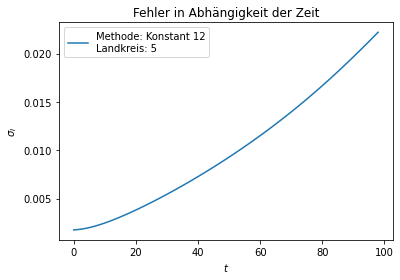

In [250]:
lk = 5
dim = 12
err = err_12_const
state = state_12_const
solt = solt_12_const
plt.plot(solt[:len(err[dim+lk])],err[dim+lk], label = "Methode: Konstant 12\nLandkreis: 5")
plt.title("Fehler in Abhängigkeit der Zeit")
plt.ylabel(r'$\sigma_I$')
plt.xlabel('$t$')
plt.legend()

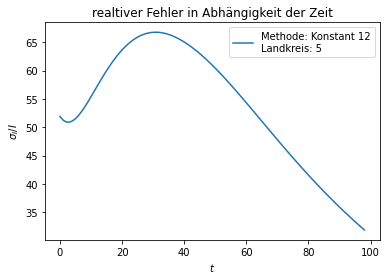

In [251]:
lk = 5
dim = 12
err = err_12_const
state = state_12_const
solt = solt_12_const
plt.plot(solt[:len(err[dim+lk])],err[dim+lk]/state[dim+lk][:len(err[dim+lk])], label = "Methode: Konstant 12\nLandkreis: 5")
plt.title("realtiver Fehler in Abhängigkeit der Zeit")
plt.ylabel(r'$\sigma_I/I$')
plt.xlabel('$t$')
plt.legend()

### heaviside 12

In [280]:
method = 'heaviside'
dimension = 12
number_of_Lks = dimension
params = params_12_heavi 
d_params = d_params_12_heavi
Sigma, solt_12_heavi, state_12_heavi = make_sim(params, d_params, method, dimension, t_depth = 3000)
Kov_12_heavi = Kovarianz(Sigma,state_12_heavi, solt_12_heavi, number_of_Lks, method, params, 2997)
err_12_heavi = error_of_state(Kov_12_heavi, state_12_heavi, dimension)
#np.save("heaviside_12", err_12_heavi)


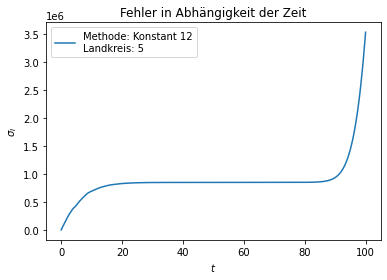

In [281]:
lk = 5
dim = 12
err = err_12_heavi
state = state_12_heavi
solt = solt_12_heavi
plt.plot(solt[:len(err[dim+lk])],err[dim+lk], label = "Methode: Konstant 12\nLandkreis: 5")
plt.title("Fehler in Abhängigkeit der Zeit")
plt.ylabel(r'$\sigma_I$')
plt.xlabel('$t$')
plt.legend()

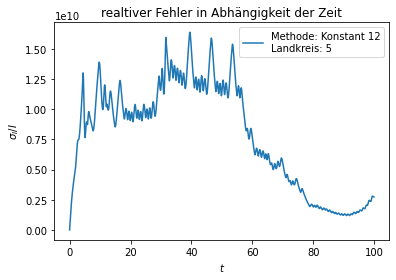

In [282]:
lk = 5
dim = 12
err = err_12_heavi
state = state_12_heavi
solt = solt_12_heavi
plt.plot(solt[:len(err[dim+lk])],err[dim+lk]/state[dim+lk][:len(err[dim+lk])], label = "Methode: Konstant 12\nLandkreis: 5")
plt.title("realtiver Fehler in Abhängigkeit der Zeit")
plt.ylabel(r'$\sigma_I/I$')
plt.xlabel('$t$')
plt.legend()

### constant 38

In [274]:
method = 'constant'
dimension = 38
number_of_Lks = dimension
params = params_38_const
d_params = d_params_38_const
Sigma, solt_38_const, state_38_const = make_sim(params, d_params, method, dimension, t_depth = 100)
Kov_38_const = Kovarianz(Sigma,state_38_const, solt_38_const, number_of_Lks, method, params, 97)
err_38_const = error_of_state(Kov_38_const, state_38_const, dimension)
np.save("constant_38", err_38_const)
 
 

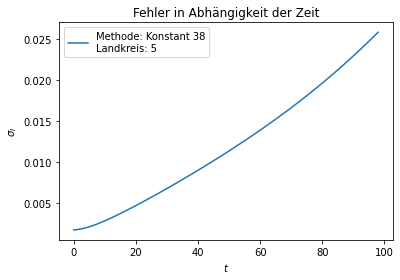

In [275]:
lk = 5
dim = 38
err = err_38_const
state = state_38_const
solt = solt_38_const
plt.plot(solt[:len(err[dim+lk])],err[dim+lk], label = "Methode: Konstant 38\nLandkreis: 5")
plt.title("Fehler in Abhängigkeit der Zeit")
plt.ylabel(r'$\sigma_I$')
plt.xlabel('$t$')
plt.legend()

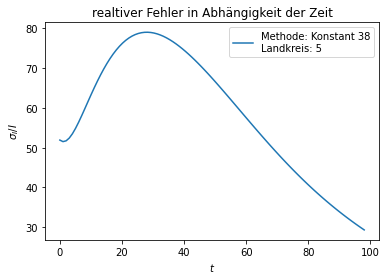

In [276]:
lk = 5
dim = 38
err = err_38_const
state = state_38_const
solt = solt_38_const
plt.plot(solt[:len(err[dim+lk])],err[dim+lk]/state[dim+lk][:len(err[dim+lk])], label = "Methode: Konstant 38\nLandkreis: 5")
plt.title("realtiver Fehler in Abhängigkeit der Zeit")
plt.ylabel(r'$\sigma_I/I$')
plt.xlabel('$t$')
plt.legend()

### heaviside 38

In [ ]:
method = 'heaviside'
dimension = 38
number_of_Lks = dimension
params = params_38_heavi 
d_params = d_params_38_heavi
Sigma, solt_38_heavi, state_38_heavi = make_sim(params, d_params, method, dimension, t_depth = 200)
Kov_38_heavi = Kovarianz(Sigma,state_38_heavi, solt_38_heavi, number_of_Lks, method, params, 1097)
err_38_heavi = error_of_state(Kov_38_heavi, state_38_heavi, dimension)
#np.save("heaviside_38", err_38_heavi)


In [ ]:
lk = 5
dim = 38
err = err_38_heavi
state = state_38_heavi
solt = solt_38_heavi
plt.plot(solt[:len(err[dim+lk])],err[dim+lk], label = "Methode: Stufen-Ansatz 38\nLandkreis: 5")
plt.title("Fehler in Abhängigkeit der Zeit")
plt.ylabel(r'$\sigma_I$')
plt.xlabel('$t$')
plt.legend()

In [ ]:
lk = 5
dim = 38
err = err_38_heavi
state = state_38_heavi
solt = solt_38_heavi
plt.plot(solt[:len(err[dim+lk])],err[dim+lk]/state[dim+lk][:len(err[dim+lk])], label = "Methode: Stufen-Ansatz 38\nLandkreis: 5")
plt.title("realtiver Fehler in Abhängigkeit der Zeit")
plt.ylabel(r'$\sigma_I/I$')
plt.xlabel('$t$')
plt.legend()

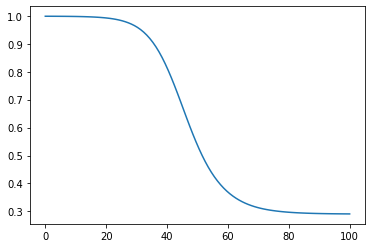

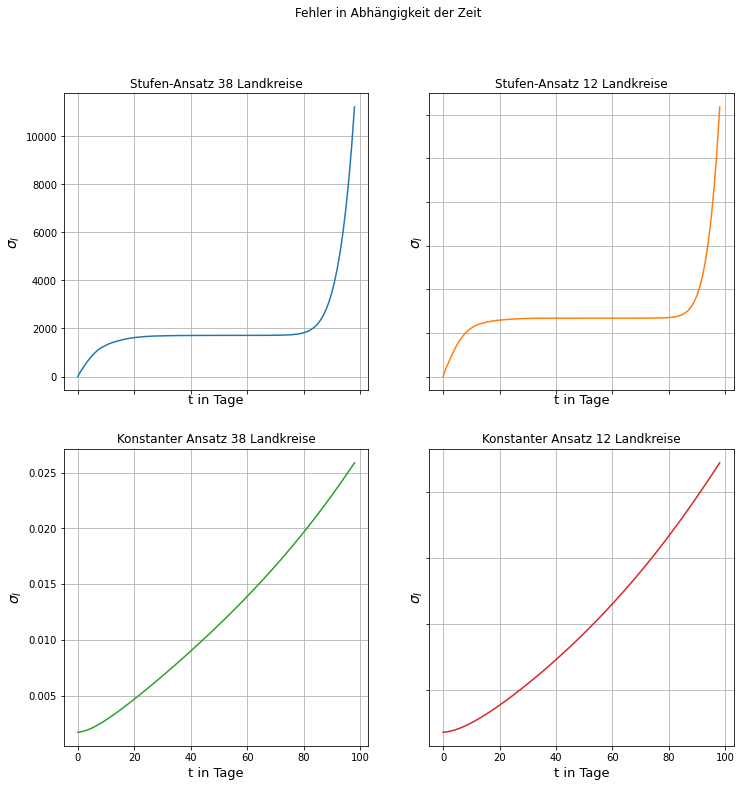

In [277]:
lk = 5
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(12,12))
fig.suptitle('Fehler in Abhängigkeit der Zeit')
ax1.plot(solt_38_heavi[:len(err_38_heavi[38+lk])], err_38_heavi[38+lk], label = "Stufen-Ansatz 38 Landkreise")
ax2.plot(solt_12_heavi[:len(err_12_heavi[12+lk])], err_12_heavi[12+lk], 'tab:orange',label = "Stufen Ansatz 12 Landkreise")
ax3.plot(solt_38_const[:len(err_38_const[38+lk])], err_38_const[38+lk], 'tab:green',label = "Konstanter Ansatz 38 Landkreise")
ax4.plot(solt_12_const[:len(err_12_const[12+lk])], err_12_const[12+lk], 'tab:red',label = "Konstanter Ansatz 12 Landkreise")

for ax in fig.get_axes():
    ax.label_outer()
    ax.set_ylabel(ylabel=r'$\sigma_I$', fontsize = 14.)
    ax.set_xlabel(xlabel='t in Tage', fontsize = 13.)
    ax.grid()
ax1.set_title("Stufen-Ansatz 38 Landkreise")
ax2.set_title("Stufen-Ansatz 12 Landkreise")
ax3.set_title("Konstanter Ansatz 38 Landkreise")
ax4.set_title("Konstanter Ansatz 12 Landkreise")
fig.savefig("err_abs.png")

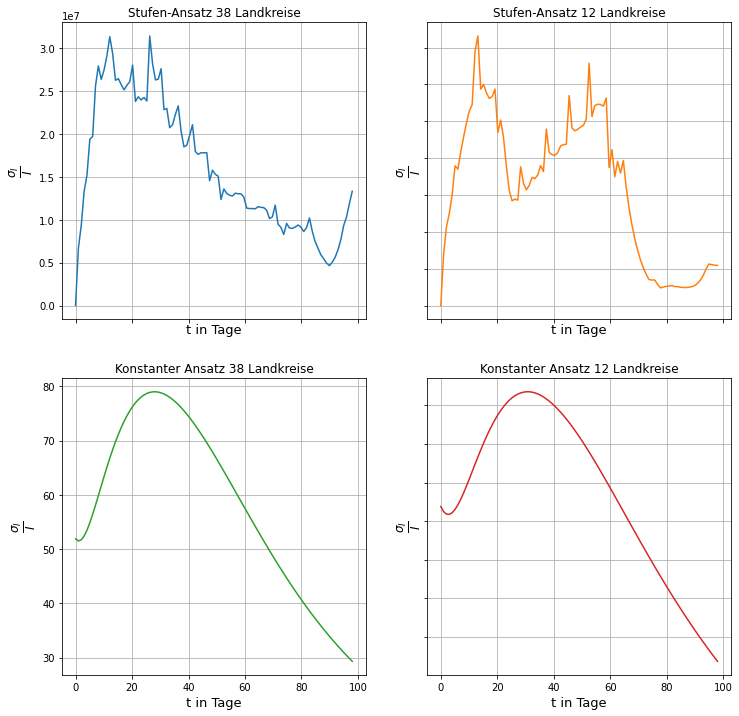

In [278]:
lk = 5
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(12,12))
#fig.suptitle('Relativer Fehler in Abhängigkeit der Zeit')
ax1.plot(solt_38_heavi[:len(err_38_heavi[38+lk])], err_38_heavi[38+lk]/state_38_heavi[38+lk][:len(err[38+lk])], label = "Stufen-Ansatz 38 Landkreise")
ax2.plot(solt_12_heavi[:len(err_12_heavi[12+lk])], err_12_heavi[12+lk]/state_12_heavi[12+lk][:len(err[12+lk])], 'tab:orange',label = "Stufen Ansatz 12 Landkreise")
ax3.plot(solt_38_const[:len(err_38_const[38+lk])], err_38_const[38+lk]/state_38_const[38+lk][:len(err[38+lk])], 'tab:green',label = "Konstanter Ansatz 38 Landkreise")
ax4.plot(solt_12_const[:len(err_12_const[12+lk])], err_12_const[12+lk]/state_12_const[12+lk][:len(err[dim+lk])], 'tab:red',label = "Konstanter Ansatz 12 Landkreise")

for ax in fig.get_axes():
    ax.label_outer()
    #ax.set(xlabel='t in Tage', ylabel=r'$\frac{\sigma_I}{I}$', fontsize = 20.)
    ax.set_ylabel(ylabel=r'$\frac{\sigma_I}{I}$', fontsize = 17.)
    ax.set_xlabel(xlabel='t in Tage', fontsize = 13.)
    ax.grid()
ax1.set_title("Stufen-Ansatz 38 Landkreise")
ax2.set_title("Stufen-Ansatz 12 Landkreise")
ax3.set_title("Konstanter Ansatz 38 Landkreise")
ax4.set_title("Konstanter Ansatz 12 Landkreise")
fig.savefig("err.png")

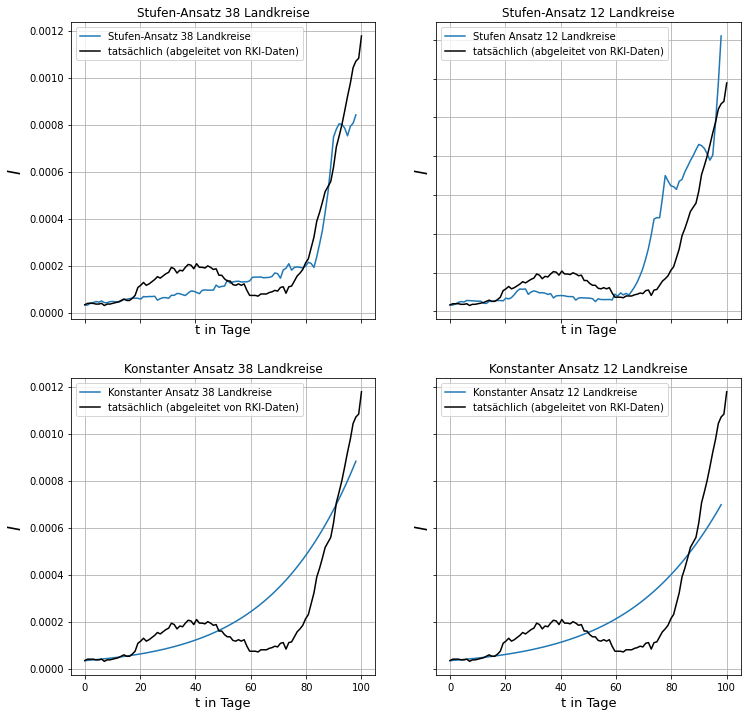

In [273]:
lk = 5
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(12,12))
#fig.suptitle('Relativer Fehler in Abhängigkeit der Zeit')
ax1.plot(solt_38_heavi[:len(err_38_heavi[38+lk])], state_38_heavi[38+lk][:len(err[38+lk])], label = "Stufen-Ansatz 38 Landkreise")
ax2.plot(solt_12_heavi[:len(err_12_heavi[12+lk])], state_12_heavi[12+lk][:len(err[12+lk])], label = "Stufen Ansatz 12 Landkreise")
ax3.plot(solt_38_const[:len(err_38_const[38+lk])], state_38_const[38+lk][:len(err[38+lk])], label = "Konstanter Ansatz 38 Landkreise")
ax4.plot(solt_12_const[:len(err_12_const[12+lk])], state_12_const[12+lk][:len(err[dim+lk])], label = "Konstanter Ansatz 12 Landkreise")
times = np.linspace(0,100,100)
#times,I_RKI[5]

for ax in fig.get_axes():
    ax.label_outer()
    ax.plot(times,I_RKI[5],color ='black', label ="tatsächlich (abgeleitet von RKI-Daten)")
    #ax.set(xlabel='t in Tage', ylabel=r'$\frac{\sigma_I}{I}$', fontsize = 20.)
    ax.set_ylabel(ylabel=r'$I$', fontsize = 17.)
    ax.set_xlabel(xlabel='t in Tage', fontsize = 13.)
    ax.grid()
    ax.legend()
ax1.set_title("Stufen-Ansatz 38 Landkreise")
ax2.set_title("Stufen-Ansatz 12 Landkreise")
ax3.set_title("Konstanter Ansatz 38 Landkreise")
ax4.set_title("Konstanter Ansatz 12 Landkreise")
fig.savefig("optparams.png")

(100,)

In [267]:
def propagator(Sigma,state, solt, number_of_Lks, method, params, times = -1):
    n = number_of_Lks
    if times == -1:
        times = len(solt)
    ## finde h_j
    h = []
    dt = solt[1] - solt[0]
    A = []
    B = []
    Kov = [Sigma]
    for j in range(times):
        if j+1<times:
            dt = solt[j+1] - solt[j]
        h.append(dt)
        A.append(np.identity(n*4) + h[j] *Jacobian(state, solt, number_of_Lks, method, params, j))
        B.append(Jacobian_F(state, solt, number_of_Lks, method, params, j)*h[j])
    M = [np.hstack((A[i],B[i])) for i in range(len(A))]
    for i in range(len(M)):
        Matrix = M[i]
        res = Sigma*0
        res = res + np.dot(Matrix,np.dot(Kov[i], Matrix.T))
        #Matrix.dot(Kov[i].dot(Matrix.T))
        print(res.shape)
        Kov.append(res)
    return Kov
    

In [ ]:
heavi_12_err = error_of_state(Kov_12_heavi, state, dimension)
lk = 5
err = heavi_12_err
plt.plot(solt[:len(err[38])],err[38+lk], label = "heaviside 12")
plt.title("Fehler in Abhängigkeit der Zeit")
plt.ylabel(r'$\sigma_I$')
plt.xlabel('$t$')
plt.legend()

In [ ]:
plt.plot(solt[:len(err[38])],err[38+lk]/state[38+lk][:len(err[38])], label = "heaviside 12")
plt.title("realtiver Fehler in Abhängigkeit der Zeit")
plt.ylabel(r'$\sigma_I/I$')
plt.xlabel('$t$')
plt.legend()

In [ ]:
plt.plot(solt[:len(err[38])],err[38+lk]/state[38+lk][:len(err[38])], label = "constant 38")
plt.title("relativer Fehler in Abhängigkeit der Zeit")
plt.ylabel(r'$\sigma_I/I$')
plt.xlabel('$t$')
plt.legend()